In [2]:
import imgaug as ia
import imgaug.augmenters as iaa
import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset
import cv2
import numpy as np
from sklearn.decomposition import PCA
from google.colab import drive
import math
from torchvision.utils import make_grid
import os, glob
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.nn import init
from torchvision.models import resnet18
from torch.utils.data import DataLoader
from PIL import Image
import time

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


4.150404691696167


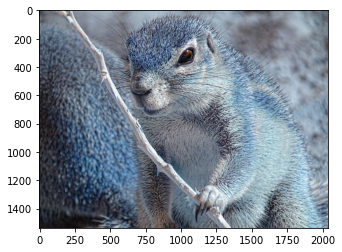

In [4]:
#testing purpose code
import matplotlib 
start = time.time()
img = cv2.imread("/content/drive/My Drive/CS_663_project/DIV2K_train_HR/0776.png", cv2.IMREAD_COLOR)
matplotlib.pyplot.imshow(img)
end = time.time()
print(end-start)

In [5]:
default_augmentations = iaa.Sequential([
            iaa.Fliplr(0.5),
            iaa.Flipud(0.5), 
            iaa.Rot90([0, 1, 2, 3])])

default_transforms = transforms.ToTensor()

KERNEL_SIZE = 21

In [6]:
class KernelImagePair(Dataset):
    def __init__(self, imgs:list, 
                 kernel_pickle:str,
                 scale:int,
                 augmentations:object,
                 transforms:object,
                 seed=0,
                 patch_size=(256,256),
                 train=True, noise=False, interpolation="cubic", downsample_on_pipe=True):
        super(KernelImagePair, self).__init__()
        self._kernel_dict = torch.load(kernel_pickle)
        
        self.kernels = self._kernel_dict['kernels']  # N x (21*21) 2d
        self.kernel_size = (KERNEL_SIZE, KERNEL_SIZE)  # (21, 21)
        self.k_reduced = self._kernel_dict['kernels_compressed']  # N x 21  2d
        self.stddevs = self._kernel_dict['sigmas']  # N standard deviations

        self.pca = self._kernel_dict['pca']  # PCA object (sklearn.decomposition)
        
        self.imgs = imgs
        self.scale = scale
        self.augmentations = augmentations
        
        self.transforms = transforms
        self.seed = seed
        self.patch_size = patch_size
        self.train=train
        self.downsample_on_pipe = downsample_on_pipe
        
        if interpolation == "cubic":
            self.inter = cv2.INTER_CUBIC

        self.random = np.random.RandomState(seed)
        self.noise = None
        if noise:
            self.noise = iaa.AdditiveGaussianNoise(scale=(0.03*255, 0.1*255))
            
    def __getitem__(self, idx) -> dict:
        img = self.imgs[idx]
        img = cv2.imread(img, cv2.IMREAD_COLOR)
        
        if self.train:
            """
            Random Crop image Adding margin w.r.t kernel_size and patch_size
            """
            img_from, img_to = np.zeros(2, dtype=int), np.zeros(2, dtype=int)
            for i in range(2):
                img_from[i] = self.random.randint(0, img.shape[i] - (self.kernel_size[i] + 1 + self.patch_size[i]))
                img_to[i] = img_from[i] + self.kernel_size[i] + 1 + self.patch_size[i]
            img_patch = img[img_from[0]:img_to[0], img_from[1]:img_to[1]]
        else:
            img_patch = img
        
        if self.train and self.augmentations is not None:
            img_patch = self.augmentations.augment_image(img_patch)
            img = img_patch
        
        # Select kernel randomly
        kernel_idx = self.random.randint(len(self.kernels))
        stddev = self.stddevs[kernel_idx]

        gaussian_kernel = self.kernels[kernel_idx].reshape(KERNEL_SIZE, KERNEL_SIZE).astype(np.float32)

        if self.downsample_on_pipe:
            img_blur = cv2.filter2D(img_patch, ddepth=-1, kernel=gaussian_kernel)
        else:
            img_blur = img_patch

        k_reduced = self.k_reduced[kernel_idx].astype(np.float32)

        if self.train:            
            
            half = self.kernel_size[0] // 2 + 1, self.kernel_size[1] // 2 + 1
            img_blur = img_blur[half[0] : -half[0], half[1]:-half[1]]
            img = img[half[0] : -half[0], half[1]:-half[1]]
            img_lr = cv2.resize(img_blur, 
                                (self.patch_size[0]//self.scale, self.patch_size[1]//self.scale), self.inter)
        if self.noise is not None:
                img_lr = self.noise.augment_image(img_lr)
        if self.downsample_on_pipe:
            img_lr = cv2.resize(img_blur, 
                    (img.shape[1]//self.scale, img.shape[0]//self.scale), self.inter)
        else:
            img_lr = img_blur
            img = cv2.imread(self.imgs[idx].replace("/lr/", "/hr/"))

        if self.transforms is not None:
            if self.train:
                
                if not img_lr.flags['C_CONTIGUOUS']:
                    img_lr = np.ascontiguousarray(img_lr)
                if not img.flags['C_CONTIGUOUS']:
                    img = np.ascontiguousarray(img)

            img_lr = self.transforms(img_lr)
            img = self.transforms(img)
        

        re_dict = dict(LR=img_lr,
                    HR=img,
                    k=gaussian_kernel,
                    k_reduced=k_reduced,
                    stddev=stddev,
                    )      
        return re_dict

    def __len__(self):
        return len(self.imgs)

In [7]:

def tensor2img(tensor, out_type=np.uint8, min_max=(0, 1)):
    '''
    Converts a torch Tensor into an image Numpy array
    Input: 4D(B,(3/1),H,W), 3D(C,H,W), or 2D(H,W), any range, RGB channel order
    Output: 3D(H,W,C) or 2D(H,W), [0,255], np.uint8 (default)
    '''
    tensor = tensor.squeeze().float().cpu().clamp_(*min_max)  # clamp
    tensor = (tensor - min_max[0]) / (min_max[1] - min_max[0])  # to range [0,1]
    n_dim = tensor.dim()
    if n_dim == 4:
        n_img = len(tensor)
        img_np = make_grid(tensor, padding=0, nrow=1, normalize=False).numpy()
        img_np = np.transpose(img_np[[2, 1, 0], :, :], (1, 2, 0))  # HWC, BGR
    else:
        raise TypeError(
            'Only support 4D, 3D and 2D tensor. But received with dimension: {:d}'.format(n_dim))
    if out_type == np.uint8:
        img_np = (img_np * 255.0).round()
        # Important. Unlike matlab, numpy.unit8() WILL NOT round by default.
    return img_np.astype(out_type)

In [8]:
def get_datasets(args):
    train_imgs = glob.glob("/content/drive/My Drive/CS_663_project/DIV2K_train_HR/*.png", recursive=True)
    valid_imgs = glob.glob("/content/drive/My Drive/CS_663_project/DIV2K_valid_HR/*.png", recursive=True)

    if args.augment == "default":
        augmentations = default_augmentations

    print(f"num of train {len(train_imgs)},  num of valid {len(valid_imgs)}.")

    train_dataset = KernelImagePair(imgs=train_imgs, 
                                    kernel_pickle=args.train_kernel, scale=args.scale, 
                                    augmentations=default_augmentations, transforms=default_transforms, 
                                    patch_size=(args.patch_size, args.patch_size),
                                    seed=args.seed, train=True, noise=args.use_noise, interpolation=args.inter)

    valid_dataset = KernelImagePair(imgs=valid_imgs, 
                                    kernel_pickle=args.train_kernel, scale=args.scale, 
                                    augmentations=default_augmentations, transforms=default_transforms, 
                                    patch_size=(args.patch_size, args.patch_size),
                                    seed=args.seed, train=True, interpolation=args.inter)

    rt_dict = dict(train_dataset=train_dataset,valid_dataset=valid_dataset)
    
    return rt_dict

In [9]:
#import PinkBlack.io
#from PinkBlack.trainer import Trainer
import torch.optim as optim
from sklearn.decomposition import KernelPCA, PCA
#from network.sftmd import SFTMD, Predictor, Corrector

#from radam import RAdam

In [10]:
class args():
    def __init__(self):
        self.scale = 4
        self.train_kernel = "/content/drive/My Drive/CS_663_project/kernels_scale4dim10.pth"
        self.inter = "cubic"
        self.seed = None
        self.patch_size = 256
        self.augment = "default"
        self.use_noise = True
        self.batch_size=32
        self.num_step=200 # Epochs 
        self.validation_interval=500
        self.num_workers=8
        self.lr=0.0001
        self.lr_decay=0.5
        self.lr_min=1e-7
        self.lr_scheduler="cosine" 
        self.optimizer="adam"
        self.loss="l2"
        self.metric="psnr"
        self.resume=False
        self.nf=64
        self.valid_rate=0.1
        self.kernel_dim=10
args = args()

In [11]:
class Predictor(nn.Module):
    def __init__(self, pca, in_nc=3, nf=64, code_len=10, use_bias=True, kernel_size=10, original=False):
        super(Predictor, self).__init__()
        self.pca = pca
        self.register_buffer("mean_", torch.tensor(pca.mean_, dtype=torch.float32))
        self.register_buffer("components_", torch.tensor(pca.components_, dtype=torch.float32))
        self.code_len = code_len
        self.kernel_size = kernel_size
        self.original = original #original implementation : which returns reducted codes.

        self.ConvNet = nn.Sequential(*[
            nn.Conv2d(in_nc, nf, kernel_size=5, stride=1, padding=2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf, nf, kernel_size=5, stride=1, padding=2, bias=use_bias),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf, nf, kernel_size=5, stride=1, padding=2, bias=use_bias),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf, nf, kernel_size=5, stride=2, padding=2, bias=use_bias),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf, nf, kernel_size=5, stride=1, padding=2, bias=use_bias),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf, code_len, kernel_size=5, stride=1, padding=2, bias=use_bias),
            nn.LeakyReLU(0.2, True),
        ])

        self.globalPooling = nn.AdaptiveAvgPool2d((1,1))

    def forward(self, bd, recon_kernel=False):
        input = bd['LR']
        conv = self.ConvNet(input)
        flat = self.globalPooling(conv)
        flat = flat.view(flat.size()[:2]) # torch size: [B, code_len]
        if self.original or not recon_kernel:
            return flat

        if recon_kernel:
            recon = self.get_recon(flat)
            return recon
        else:
            return flat
        


In [12]:
datasets = get_datasets(args)
print(f"datasets are prepared.")

num of train 800,  num of valid 100.
datasets are prepared.


In [13]:
train_dl = DataLoader(datasets['train_dataset'], batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers, pin_memory=True)
valid_dl = DataLoader(datasets['valid_dataset'], batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers, pin_memory=True)

In [14]:
net = Predictor(datasets['train_dataset'].pca, code_len=args.kernel_dim).cuda()

In [15]:
import matplotlib
mean_ = net.mean_
components_ = net.components_
def get_recon(flat):
  batch_mean = mean_.expand(flat.shape[0], 441)
  recon = torch.matmul(flat, components_) + batch_mean
  return recon


In [16]:
def train_predictor(train_dl,valid_dl, model, epochs, optimizer, loss_func,batch_size,scheduler):
    matplotlib.use("Agg")
    os.makedirs("/content/drive/My Drive/CS_663_project/valid_results/", exist_ok=True)
    os.makedirs("/content/drive/My Drive/CS_663_project/result_imgs/", exist_ok=True)
   
   
    for t in range(epochs):  
      
      if t%15 == 0:
        with torch.no_grad(): 
            bd = next(iter(valid_dl))
            for k,v in bd.items():
                bd[k] = v.cuda()    
            
            estimated = net(bd)
            estimated_recon = get_recon(estimated)
            gt_recon = get_recon(bd['k_reduced'])
            #fig = plt.figure()
            #matplotlib.pyplot.imshow(estimated_recon[0].view(21, 21).cpu().numpy(), cmap="gray")
            fig = estimated_recon[0].view(21, 21).cpu().numpy()
            pth = str(t)+"_es.png"
            cv2.imwrite(os.path.join(os.path.sep, "content", "drive", "My Drive", "CS_663_project", "Predictor", "result_imgs",pth), fig)# '/content/drive/My Drive/CS_663_project/Predictor/ '+ f"result_imgs/{t}_es.png",img )
            # matplotlib.pyplot.savefig("/content/drive/My Drive/CS663_project/ "+ f"result_imgs/{t}_es.png")  
            #plt.close(fig)

            #fig = plt.figure()
            #plt.imshow(gt_recon[0].view(21, 21).cpu().numpy(), cmap="gray")
            # matplotlib.pyplot.savefig(trainer.ckpt + f"result_imgs/{t}_gt.png")
            #plt.close(fig)
      loss_calc = 0
      for batch in train_dl:
        input = batch
        for k,v in input.items():
          input[k] = v.cuda() 
        gt_hr = input['k_reduced']
        sr = model(input)
        loss = loss_func(sr, gt_hr)
        loss_calc += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      scheduler.step(loss_calc)
      #end = time.time()
      #print(end-start)
      
      print(loss_calc)
      

        

In [17]:
loss = F.mse_loss

In [18]:
if args.optimizer == "adam":
    optimizer = torch.optim.Adam(filter(lambda x: x.requires_grad, net.parameters()), lr=args.lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=5, factor=args.lr_decay)

In [ ]:
train_predictor(train_dl=train_dl,valid_dl=valid_dl,model= net,epochs=args.num_step, optimizer=optimizer, loss_func=loss,batch_size=args.batch_size,scheduler =scheduler)

tensor(0.0770, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0857, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0829, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0835, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0880, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0959, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0810, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0868, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0862, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0870, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0855, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0866, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0838, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0813, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0843, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0899, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0803, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0873, device='cuda:0', grad_fn=<AddBack

KeyboardInterrupt: ignored

In [1]:
PATH = "/content/drive/My Drive/CS_663_project/Pre-TrainedModels/Pred_final.pth"
torch.save(net.state_dict(), PATH)

NameError: ignored

In [19]:
net = Predictor(datasets['train_dataset'].pca, code_len=args.kernel_dim).cuda()
net.load_state_dict(torch.load("/content/drive/My Drive/CS_663_project/Pre-TrainedModels/Pred_final.pth"))
net.eval() 


Predictor(
  (ConvNet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(64, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (globalPooling): AdaptiveAvgPool2d(output_size=(1, 1))
)

In [20]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=40, eta_min=args.lr_min) 

In [21]:
train_predictor(train_dl=train_dl,valid_dl =valid_dl,model= net,epochs=args.num_step, optimizer=optimizer, loss_func=loss,batch_size=args.batch_size,scheduler =scheduler)

tensor(0.0715, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0673, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0668, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0644, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0624, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0643, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0609, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0717, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0663, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0685, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0665, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0627, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0685, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0619, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0662, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0654, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0662, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0671, device='cuda:0', grad_fn=<AddBack

KeyboardInterrupt: ignored

In [ ]:
PATH = "/content/drive/My Drive/CS_663_project/Pre-TrainedModels/Pred_final_250.pth"
torch.save(net.state_dict(), PATH)